In [ ]:
import torch
import matplotlib.pyplot as plt
import sys
import os
import numpy as np 
import os.path as osp
import pickle
#from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import shutil

from tqdm import tqdm

In [16]:
np.random.seed(42)

T = 30 
M = 121 # sensor 개수
D = np.linspace(0, T, M) # sensor
interp_M = 31
interp_D = np.linspace(0, T, interp_M)

N = 1000 # train data 개수
test_N=200 # test data 개수


S0 = 350
I0 = 10 
R0 = 2.5 # basic reproduction number
gamma  = 0.25
beta = R0*gamma/S0

x0 = (S0,I0) # initial condition
#dict_D = {v:i for i,v in enumerate(D)}

In [3]:
def func(t,Y,u): # Y[0] = S, Y[1] = I
    return -beta*Y[0]*Y[1]-u(t)*Y[0], beta*Y[0]*Y[1]-gamma*Y[1]

In [4]:
train_x = []
train_y = []
test_x = []
test_y = []

#Train data
for i in tqdm(range(N)):
    interp_x = np.random.rand(interp_M)
    u = interp1d(interp_D, interp_x, kind='cubic')
    sol = solve_ivp(func, (0,T), x0, method='RK45',t_eval=D,args=(u,))
    x = u(D)
    
    for j in D:
        train_x.append(np.append(x, j))

    for j in range(len(D)):
        train_y.append(sol.y[:,j])

train_x = torch.as_tensor(train_x).reshape(N*len(D), len(D) + 1) 
train_y = torch.as_tensor(train_y).reshape(N*len(D),2)
print('train_data_done')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.96it/s]


train_data_done


In [5]:
#Test data
for i in tqdm(range(test_N)):
    interp_x = np.random.rand(interp_M)
    u = interp1d(interp_D, interp_x, kind='cubic')
    sol = solve_ivp(func, (0,T), x0, method='RK45',t_eval=D,args=(u,))
    x = u(D)
    
    for j in D:
        test_x.append(np.append(x, j))

    for j in range(len(D)):
        test_y.append(sol.y[:,j])

test_x = torch.as_tensor(test_x).reshape(test_N*len(D), len(D) + 1)
test_y = torch.as_tensor(test_y).reshape(test_N*len(D), 2)
print('test_data_done')

data = {'train_X' : train_x, 'train_Y' : train_y, 'test_X' : test_x, 'test_Y' : test_y, 'M' : len(D)}

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.29it/s]


test_data_done


In [6]:
make_data=True
file_name='SIR_v3_N'+str(N)+'_M'+str(M)+'_int'+str(interp_M)+'.pickle'

if make_data:
    with open(file_name,"wb") as fw:
        pickle.dump(data, fw)
    load_data=data
    print(file_name, 'is saved')
else:
    ## load dataset
    with open(file_name,"rb") as fr:
        load_data= pickle.load(fr)
        print(file_name, 'is loaded')

SIR_v3_N1000_M121_int11.pickle is saved


In [7]:
print(load_data['train_X'].shape,load_data['train_Y'].shape,load_data['test_X'].shape,load_data['test_Y'].shape)

torch.Size([121000, 122]) torch.Size([121000, 2]) torch.Size([24200, 122]) torch.Size([24200, 2])


## viz

In [8]:
# idx=np.random.randint(0,N)

# x=load_data['train_X'][M*idx][:M]
# y=load_data['train_Y'][M*idx:M*idx+M]

# plt.figure(figsize=(10,7))
# plt.subplot(3, 1, 1)  
# plt.plot(D, x)
# plt.xlabel('t')
# plt.title('u(t)')

# plt.figure(figsize=(10,7))
# plt.subplot(3, 1, 2)  
# plt.plot(D, y[:,0],'orange')
# plt.title('S(t)')
# plt.xlabel('t')

# plt.figure(figsize=(10,7))
# plt.subplot(3, 1, 3)  
# plt.plot(D, y[:,1],'g')
# plt.title('I(t)')
# plt.xlabel('t')

# #plt.legend()

Text(0.5, 0, 't')

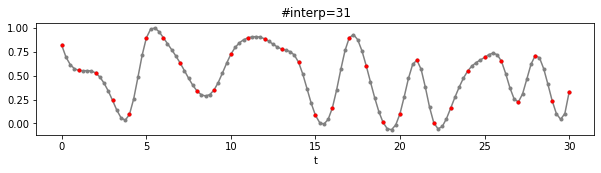

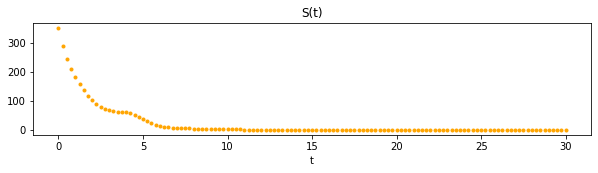

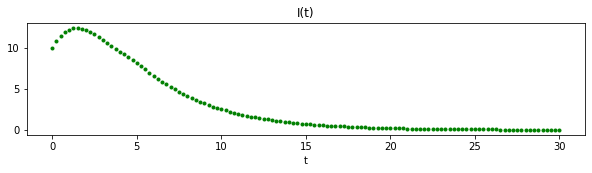

In [34]:
interp_x = np.random.rand(interp_M)
u = interp1d(interp_D, interp_x, kind='cubic')
sol = solve_ivp(func, (0,T), x0, method='RK45',t_eval=D,args=(u,))
x = u(D)

xnew = np.linspace(0, T, 10*M) # for viz
ynew = u(xnew) # for viz

plt.figure(figsize=(10,7))
plt.subplot(3, 1, 1)  
plt.plot(D,u(D),'o-',color='gray',markersize=3)
plt.plot(interp_D,interp_x,'o',color='red',markersize=3)
plt.xlabel('t')
#plt.title('u(t)')
plt.title('#interp='+str(interp_M))


plt.figure(figsize=(10,7))
plt.subplot(3, 1, 2)  
plt.plot(D, sol.y[0],'o',color='orange',markersize=3)
plt.title('S(t)')
plt.xlabel('t')

plt.figure(figsize=(10,7))
plt.subplot(3, 1, 3)  
plt.plot(D, sol.y[1],'go',markersize=3)

plt.title('I(t)')
plt.xlabel('t')

In [ ]:
max()

## Rec

In [11]:
file_name='SIR_v3_N'+str(N)+'_M'+str(M)+'_int'+str(interp_M)+'.pickle'
## load dataset
with open(file_name,"rb") as fr:
    load_data= pickle.load(fr)
    print(file_name, 'is loaded')
index_D = {k:v for v,k in enumerate(D)}

SIR_v3_N1000_M121_int11.pickle is loaded


In [12]:
index = load_data['train_X'][:,-1].clone().unsqueeze(1).apply_(lambda x:index_D[x]).to(torch.int64)
train_u = torch.gather(load_data['train_X'],1,index)
rec_train = torch.cat((load_data['train_Y'], train_u),dim=1)

index = load_data['test_X'][:,-1].clone().unsqueeze(1).apply_(lambda x:index_D[x]).to(torch.int64)
test_u = torch.gather(load_data['test_X'],1,index)
rec_test = torch.cat((load_data['test_Y'], test_u),dim=1)

rec_data = {'train_X' : load_data['train_X'], 
        'train_Y' : rec_train,
        'test_X' : load_data['test_X'],
        'test_Y' : rec_test,
        'M' : len(D)}

In [13]:
file_name='SIR_v3_rec_N'+str(N)+'_M'+str(M)+'_int'+str(interp_M)+'.pickle'
with open(file_name,"wb") as fw:
    pickle.dump(rec_data, fw)

print(file_name, 'is saved')

SIR_v3_rec_N1000_M121_int11.pickle is saved
